<a href="https://colab.research.google.com/github/Karanmanolaa/Sentiment-Analysis-Of-Threads-App-Reviews-/blob/main/Threads_App_Reviews_Data_and_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Details:

source - This column determines the platform, that the review coming from.

review_description - The review itself.

rating - The number of stars that given to the app(in that case, it's Threads).

review_date - The exact time that the person wrote the review.

In [1]:
# Importing necessary libraries
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import classification_report, accuracy_score,confusion_matrix
from sklearn import metrics
nltk.download(['punkt'])
nltk.download('stopwords')
from wordcloud import WordCloud
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
df = pd.read_csv('/content/threads_reviews.csv')

In [3]:
df.head()

,source,review_description,rating,review_date
0,Google Play,Meh. Not the greatest experience on a Chromebo...,2,2023-07-08 14:18:24
1,Google Play,Pretty good for a first launch!! Its easy to u...,3,2023-07-19 20:52:48
2,Google Play,"For a brand new app, it's very well optimized....",3,2023-07-06 23:03:11
3,Google Play,"Great app with a lot of potential! However, th...",3,2023-07-10 00:53:25
4,Google Play,"The app is good, but it needs a lot of functio...",3,2023-07-06 16:57:43


In [4]:
df.shape

(32910, 4)

In [5]:
df.dtypes

source                object
review_description    object
rating                 int64
review_date           object
dtype: object

In [6]:
df.isnull().sum()

source                0
review_description    0
rating                0
review_date           0
dtype: int64

In [7]:
# Finiding out the number of unique values and missing values in the columns
def describe(df):
    describe_df = pd.DataFrame(df.dtypes, columns=['dtypes'])
    describe_df['missing#'] = df.isna().sum()
    describe_df['uniques'] = df.nunique().values
    return describe_df

describe(df).style.background_gradient(cmap='Blues')

,dtypes,missing#,uniques
source,object,0,2
review_description,object,0,26706
rating,int64,0,5
review_date,object,0,31667


In [8]:
df.drop_duplicates(inplace=True)

## **Explolatory Data Analysis**

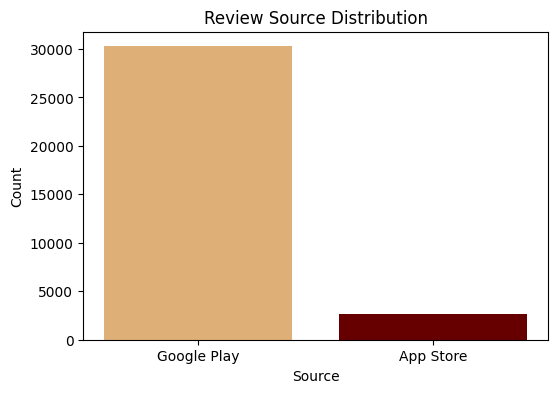

In [9]:
## checking reviews source
source_counts = df['source'].value_counts()
plt.figure(figsize=(6, 4))
plt.bar(source_counts.index, source_counts.values, color=['#DEB078', '#660000'])
plt.xlabel('Source')
plt.ylabel('Count')
plt.title('Review Source Distribution')
plt.show()

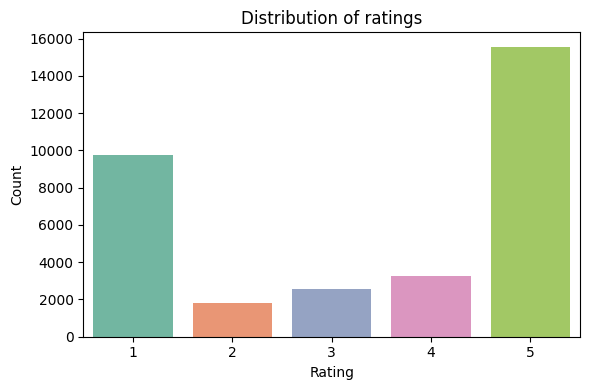

In [10]:
# Visualizing the ratings

plt.figure(figsize=(6,4))
sns.countplot(data=df, x='rating', palette='Set2')
plt.title('Distribution of ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

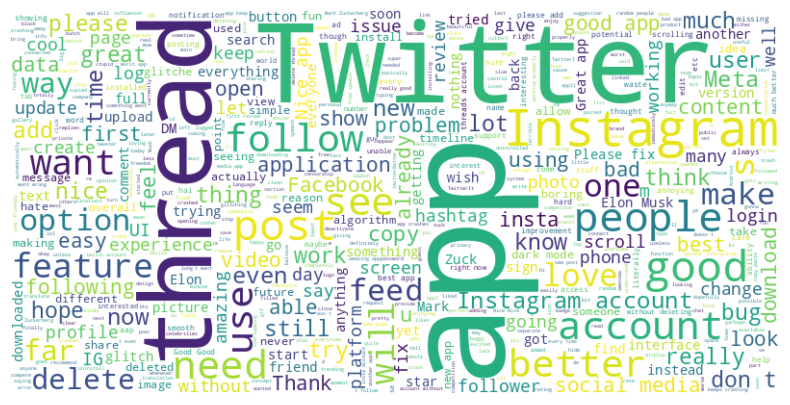

In [11]:
# Word Cloud to visualize the most frequent words
word = ''.join(df['review_description'])
word_cloud = WordCloud(width=800,
                          height=400,
                          max_words=1000,
                          background_color='white').generate(word)

plt.figure(figsize=(10,5))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#### More positive words appears, as indicated by words like: “better”, “nice”, “great”, and “love”. Some also appears negative words, such as: “bad”, “boring”, “worst”, and “useless”.

#### As anticipated, Threads app reviews prominently feature discussions about Twitter. A significant number of users are drawing comparisons between the two platforms, primarily due to the overlapping features they offer.

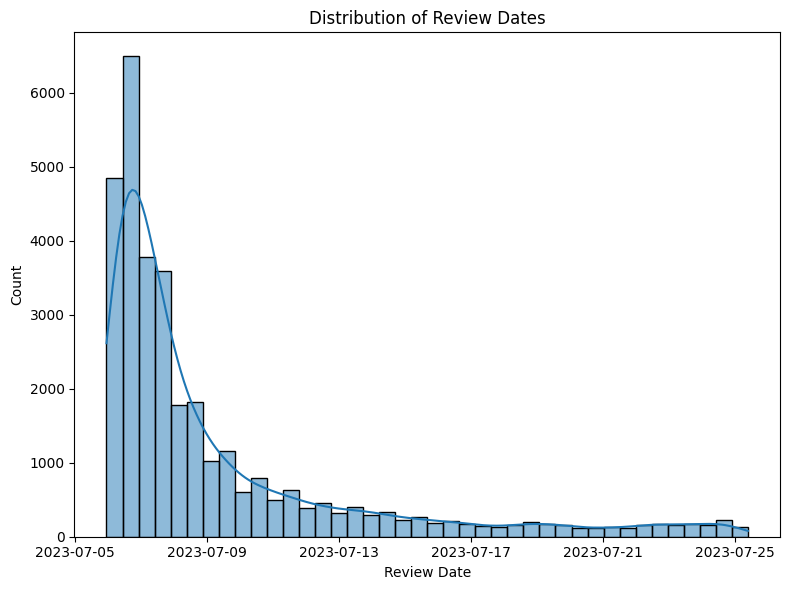

In [12]:
# Date distribution
df['review_date'] = pd.to_datetime(df['review_date'])
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x='review_date', bins=40, kde=True)
plt.title('Distribution of Review Dates')
plt.xlabel('Review Date')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

Creating an additional column in your DataFrame to determine the sentiment of each review by applying a sentiment analysis function to the text content in the 'reviews' column. The sentiment analysis function will use SentimentIntensityAnalyzer to classify the reviews as 'Positive,' 'Negative,' or 'Neutral' based on the content

In [13]:
!pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.8 MB/s eta 0:00:00


In [14]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment_vader(text):
    sentiment = analyzer.polarity_scores(text)
    if sentiment['compound'] >= 0.05:
        return "Positive"
    elif sentiment['compound'] <= -0.05:
        return "Negative"
    else:
        return "Neutral"

df['sentiment'] = df['review_description'].apply(analyze_sentiment_vader)

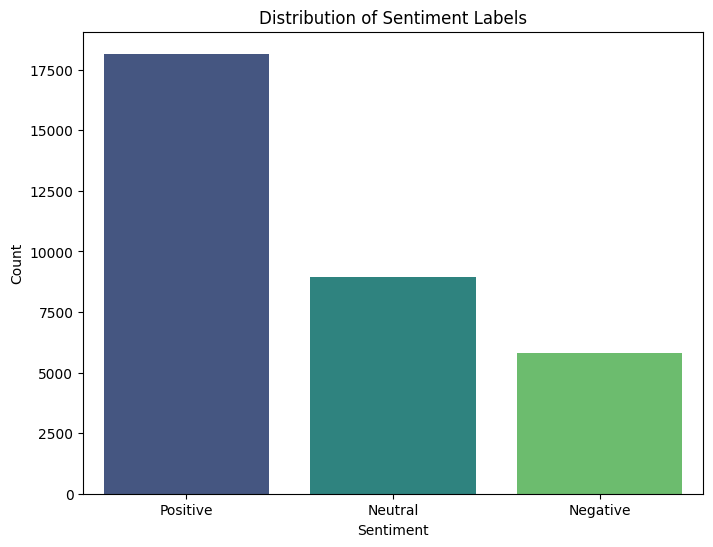

In [15]:
# Group the data by sentiment labels and count the occurrences of each label
sentiment_counts = df['sentiment'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

As we can see that the positive score are more in number as compared to negative score

In [16]:
# Make a column of text length
df['text_length'] = df.review_description.apply(lambda x: len(x))
df

,source,review_description,rating,review_date,sentiment,text_length
0,Google Play,Meh. Not the greatest experience on a Chromebo...,2,2023-07-08 14:18:24,Negative,465
1,Google Play,Pretty good for a first launch!! Its easy to u...,3,2023-07-19 20:52:48,Positive,475
2,Google Play,"For a brand new app, it's very well optimized....",3,2023-07-06 23:03:11,Positive,497
3,Google Play,"Great app with a lot of potential! However, th...",3,2023-07-10 00:53:25,Positive,487
4,Google Play,"The app is good, but it needs a lot of functio...",3,2023-07-06 16:57:43,Positive,426
...,...,...,...,...,...,...
32905,App Store,This killed my dog. Mark zuckerburg strangled ...,1,2023-07-06 01:23:55,Negative,66
32906,App Store,Add Search and hashtag like Twitter !,1,2023-07-19 08:01:06,Positive,37
32907,App Store,bad twister,1,2023-07-17 06:39:13,Negative,11
32908,App Store,Yet another trash from Meta.,1,2023-07-07 17:47:16,Neutral,28


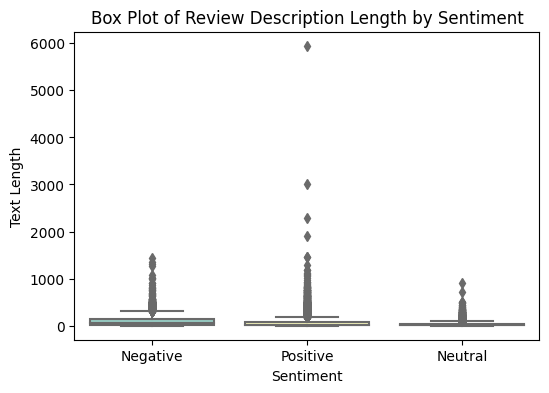

In [17]:
plt.figure(figsize=(6,4))

sns.boxplot(data=df, x='sentiment', y='text_length', palette="Set3")
plt.title('Box Plot of Review Description Length by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Text Length')
plt.show()


Remove punctuation, stop words and applying
tokenization and stemming to the sentences.


In [18]:
ps = PorterStemmer()

In [19]:
def stemming(review_description):
    desc = re.sub('[^a-zA-Z]',' ',review_description)
    desc = desc.lower()
    desc = desc.split()
    desc = [ps.stem(word) for word in desc if not word in stopwords.words('english')]
    desc = ' '.join(desc)
    return desc

In [20]:
df['review_description'] = df['review_description'].apply(stemming)

In [21]:
# Converting sentiments into numerical form
label_encoder = LabelEncoder()
df['sentiment_numerical'] = label_encoder.fit_transform(df['sentiment'])

The label encoder has converted 'Negative' to 0, 'Positive' to 2, and 'Neutral' to 1

In [22]:
df.head()

,source,review_description,rating,review_date,sentiment,text_length,sentiment_numerical
0,Google Play,meh greatest experi chromebook seem custom pho...,2,2023-07-08 14:18:24,Negative,465,0
1,Google Play,pretti good first launch easi use self explana...,3,2023-07-19 20:52:48,Positive,475,2
2,Google Play,brand new app well optim howev miss quit featu...,3,2023-07-06 23:03:11,Positive,497,2
3,Google Play,great app lot potenti howev lot need fix examp...,3,2023-07-10 00:53:25,Positive,487,2
4,Google Play,app good need lot function exampl search topic...,3,2023-07-06 16:57:43,Positive,426,2


####  TF-IDF Vectorization

In [23]:
X = df['review_description'].values
y = df['sentiment_numerical'].values

In [24]:
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(X)

In [25]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

This is an imbalanced dataset for handling it i will use SMOTE.

In [26]:
from imblearn.over_sampling import SMOTE

In [27]:
# Apply SMOTE to the entire dataset
smote = SMOTE(sampling_strategy='auto', random_state=4)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

### **MODEL BUILDING**

Naive Bias

In [28]:
from sklearn.naive_bayes import MultinomialNB
nb_classifier = MultinomialNB()

In [29]:
nb_classifier.fit(X_train, y_train)

# Predict using Naive Bayes
nb_predictions = nb_classifier.predict(X_train)

# Evaluate Naive Bayes
nb_accuracy = accuracy_score(y_train, nb_predictions)
print("Naive Bayes Training Accuracy:", nb_accuracy)

Naive Bayes Training Accuracy: 0.7458502677859232


In [30]:
# Accuracy on test data
nb_test_pred = nb_classifier.predict(X_test)
nb_test_acc = accuracy_score(y_test,nb_test_pred)
print("Naive Bayes Test Accuracy:", nb_test_acc)

Naive Bayes Test Accuracy: 0.6836827711941659


In [31]:
NB_report = classification_report(y_test, nb_test_pred)
print("Classification Report for XGBoost:\n", NB_report)

Classification Report for XGBoost:
               precision    recall  f1-score   support

           0       0.89      0.36      0.51      1155
           1       0.79      0.33      0.47      1812
           2       0.65      0.96      0.78      3615

    accuracy                           0.68      6582
   macro avg       0.78      0.55      0.58      6582
weighted avg       0.73      0.68      0.64      6582



### Random Forest

In [32]:
RF_model = RandomForestClassifier(n_estimators = 200,
                                  max_depth = None,
                                  min_samples_split= 3,
                                  min_samples_leaf=2)

In [33]:
RF_model.fit(X_train,y_train)

RandomForestClassifier(min_samples_leaf=2, min_samples_split=3,
                       n_estimators=200)

In [34]:
RF_pred_train = RF_model.predict(X_train)
RF_train_acc = accuracy_score(y_train, RF_pred_train)
print("Random Forest Training Accuracy:", RF_train_acc)

Random Forest Training Accuracy: 0.8719185626922931


In [35]:
RF_pred_test = RF_model.predict(X_test)
RF_test_acc = accuracy_score(y_test, RF_pred_test)
print("Random Forest Test Accuracy:", RF_test_acc)

Random Forest Test Accuracy: 0.8251291400790033


In [36]:
RF_report = classification_report(y_test, RF_pred_test)
print("Classification Report for Random Forest:\n", RF_report)

Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.86      0.47      0.61      1155
           1       0.76      0.89      0.82      1812
           2       0.85      0.90      0.88      3615

    accuracy                           0.83      6582
   macro avg       0.82      0.76      0.77      6582
weighted avg       0.83      0.83      0.82      6582



### XGBoost

In [37]:
xgb_classifier = xgb.XGBClassifier(n_estimators = 100, learning_rate = 0.1)

In [38]:
xgb_classifier.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [39]:
xgb_pred_train = xgb_classifier.predict(X_train)
xgb_train_acc = accuracy_score(y_train, xgb_pred_train)
print("XGBoost Training Accuracy:", xgb_train_acc)

XGBoost Training Accuracy: 0.8223876628556235


In [40]:
xgb_pred_test = xgb_classifier.predict(X_test)
xgb_test_acc = accuracy_score(y_test, xgb_pred_test)
print("XGBoost Test Accuracy:", xgb_test_acc)

XGBoost Test Accuracy: 0.8027955028866606


In [41]:
xgb_report = classification_report(y_test, xgb_pred_test)
print("Classification Report for XGBoost:\n", xgb_report)

Classification Report for XGBoost:
               precision    recall  f1-score   support

           0       0.84      0.42      0.56      1155
           1       0.67      0.95      0.79      1812
           2       0.89      0.85      0.87      3615

    accuracy                           0.80      6582
   macro avg       0.80      0.74      0.74      6582
weighted avg       0.82      0.80      0.79      6582



Thank You